# 1.0 Purpose
The purpose of this notebook is to create a Convolutional Neural Network (CNN) with TensorFlow for prediction with cats vs. dogs dataset.

# 2.0 Import Libraries

In [ ]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

# 3.0 Import Cats_vs_Dogs dataset from Kaggle

## 3.0.1 [Find your Kaggle Account and click the **Create New API Token** to download the json file](https://www.kaggle.com/stevensmiley/account?isEditing=False)

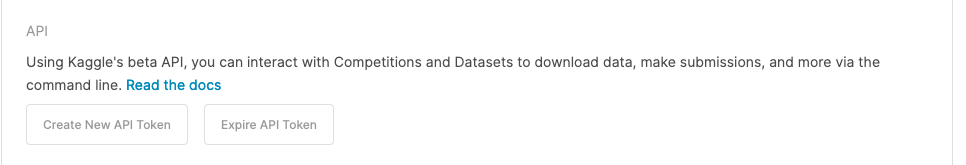

## 3.0.2 **Upload** kaggle.json file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## 3.0.3 Pick the **kaggle.json** file from your Kaggle download

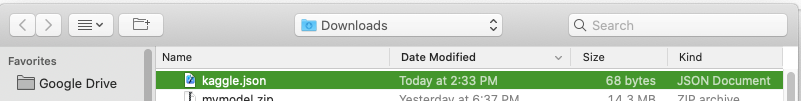

## 3.0.4 install kaggle with pip

In [ ]:
! pip install -q kaggle

## 3.0.5 create kaggle directory

In [ ]:
! mkdir ~/.kaggle 

## 3.0.6 copy the kaggle.json file to the kaggle directory

In [ ]:
! cp kaggle.json ~/.kaggle/

## 3.0.7 Set 600 permissions to a kaggle.json file so you (owner) has full read and write access to the file, while no other user can access the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## 3.0.8 List the kaggle datasets

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6765  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4016  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1353  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2111  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

## 3.0.9 download the dogs-vs-cats dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.4MB/s]
 96% 520M/543M [00:02<00:00, 278MB/s]
100% 543M/543M [00:02<00:00, 257MB/s]
100% 271M/271M [00:01<00:00, 248MB/s]
100% 271M/271M [00:01<00:00, 224MB/s]


## 3.0.9 Create **train** directory

In [ ]:
! mkdir train

## 3.0.10 Create **test** directory

In [ ]:
! mkdir test

## 3.0.11 **new_dir** 
helper function for making directories

In [ ]:
def new_dir(path):
  try:
    os.mkdir(path)
  except:
    print(f'Already have: {path}')
    pass

## 3.0.12 get_training_metrics
helper function for getting history metrics

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

## 3.0.13 plot_train_eval
helper function for plotting history metrics

In [ ]:
def plot_train_eval(history,name='',parameters='',num_images_per_epoch_train='',num_images_per_epoch_val='',batch_size=''):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('binary_crossentropy')
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()






## 3.0.14 ImageGenerator
helper function for generating augmentented images

In [ ]:
def ImageGenerator(X_train1,save_here='',id=''):
    from keras.preprocessing.image import ImageDataGenerator
    import random
    X_train1_e=X_train1

    seed=1

    datagenX = ImageDataGenerator(rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

    # prepare iterator
    datagenX.fit(X_train1_e,seed=seed)
    Xflow = datagenX.flow(X_train1_e,
                         batch_size=X_train1_e.shape[0]*2,seed=seed,shuffle=False,save_to_dir=save_here,     #this is where we figure out where to save
         save_prefix=f'aug-{id}-',        # it will save the images as 'aug_XXX' some number for every new augmented image
        save_format='jpg')


    t_x=Xflow.next()

    
    return np.squeeze(t_x)

In [ ]:
cols=['filename','model_name',
      'optimizer',
      'loss',
      'accuracy_metric',
      'batch_size','img_size',
      'steps_per_epoch','epochs','validation_steps',
      'num_images_per_epoch_train','num_images_per_epoch_val',
      'data_augmentation',
      'F1_score_dog','F1_score_cat',
      'Precision_dog','Precision_cat',
      'Recall_dog','Recall_cat',
      'misclassified_dogs','misclassified_cats']
df_metrics=pd.DataFrame(columns=cols)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats


# 4.0 **model1**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model1'
optimizer='adam'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=224
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

rm: cannot remove '/content/train_1': No such file or directory


## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

In [ ]:
model.predict(np.expand_dims(test_i[0:224,0:224,:],axis=0))

array([[1.]], dtype=float32)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

9568385

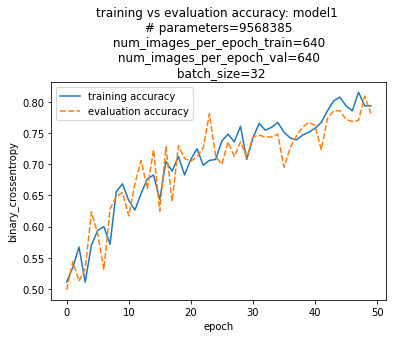

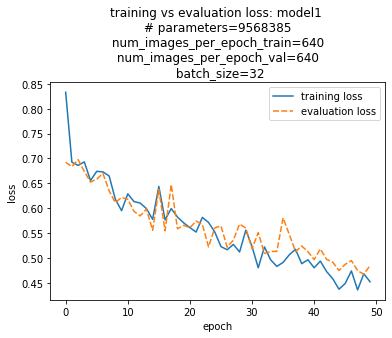

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.7866
Balanced Accuracy Score: 0.7866


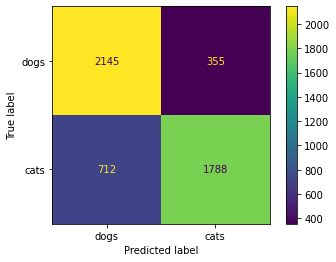

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 28.48%
Proportion of misclassified dogs: 14.20%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.858,0.7152,0.750788,0.834344,0.142,0.2848


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model1/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 5.0 **model2**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model2'
optimizer='adam'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=64
img_size=224
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  1280
num_images_per_epoch_val:  1280


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

In [ ]:
model.predict(np.expand_dims(test_i[0:224,0:224,:],axis=0))

array([[1.]], dtype=float32)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

9568385

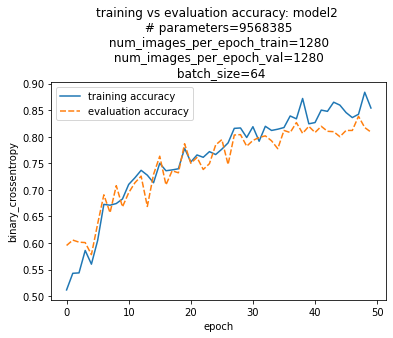

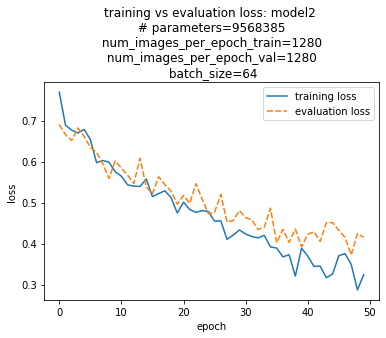

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.8258
Balanced Accuracy Score: 0.8258


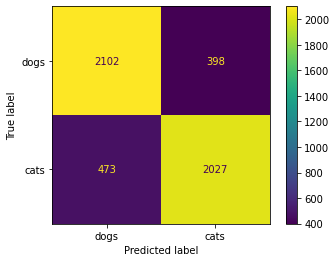

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 18.92%
Proportion of misclassified dogs: 15.92%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model2/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 6.0 **model3**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model3'
optimizer='adam'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=128
img_size=224
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  2560
num_images_per_epoch_val:  2560


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

In [ ]:
model.predict(np.expand_dims(test_i[0:224,0:224,:],axis=0))

array([[0.]], dtype=float32)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

9568385

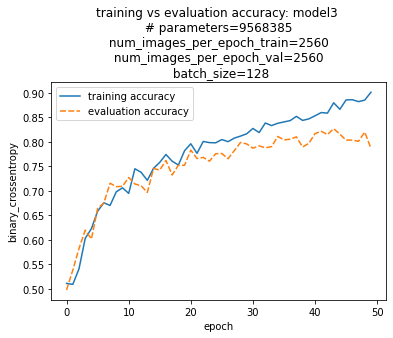

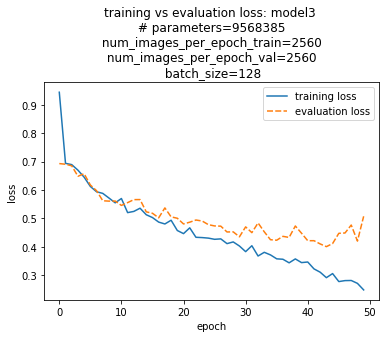

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.8018
Balanced Accuracy Score: 0.8018


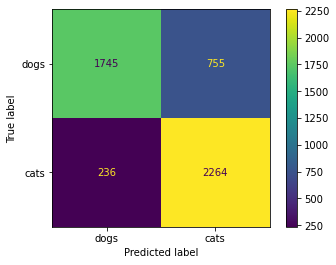

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 9.44%
Proportion of misclassified dogs: 30.20%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model3/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 7.0 **model4**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model4'
optimizer='adam'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=224
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=True

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

In [ ]:
model.predict(np.expand_dims(test_i[0:224,0:224,:],axis=0))

array([[1.]], dtype=float32)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

9568385

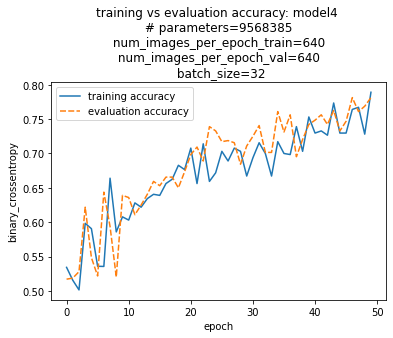

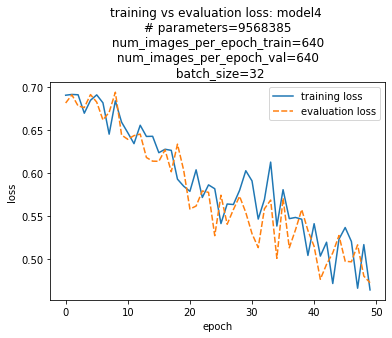

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.768
Balanced Accuracy Score: 0.768


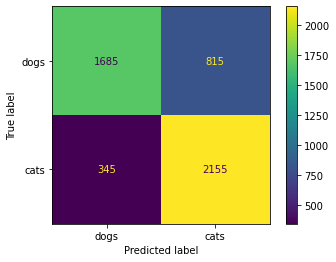

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 13.80%
Proportion of misclassified dogs: 32.60%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model4/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 8.0 **model5**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model5'
optimizer='adam'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=150
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=True

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

3342465

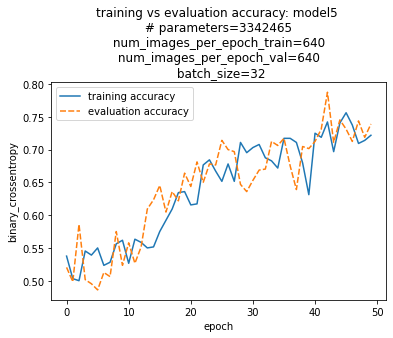

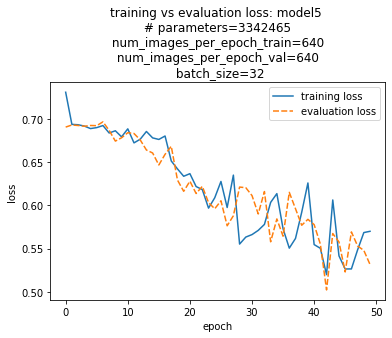

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.7434
Balanced Accuracy Score: 0.7434000000000001


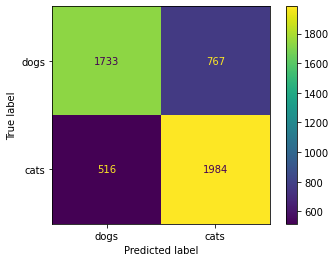

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 20.64%
Proportion of misclassified dogs: 30.68%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380
4,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model5,adam,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,True,0.729838,0.755666,0.6932,0.7936,0.770565,0.721192,0.3068,0.2064


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model5/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 9.0 **model6**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model6'
optimizer='rmsprop'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=150
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

Epoch 1/50
20/20 [==============================] - 4s 187ms/step - loss: 0.7901 - binary_accuracy: 0.4766 - val_loss: 0.6947 - val_binary_accuracy: 0.5063
Epoch 2/50
20/20 [==============================] - 3s 176ms/step - loss: 0.6885 - binary_accuracy: 0.5203 - val_loss: 0.6938 - val_binary_accuracy: 0.4906
Epoch 3/50
20/20 [==============================] - 3s 178ms/step - loss: 0.6923 - binary_accuracy: 0.5109 - val_loss: 0.6883 - val_binary_accuracy: 0.6250
Epoch 4/50
20/20 [==============================] - 3s 177ms/step - loss: 0.7076 - binary_accuracy: 0.5625 - val_loss: 0.6851 - val_binary_accuracy: 0.5547
Epoch 5/50
20/20 [==============================] - 3s 178ms/step - loss: 0.7018 - binary_accuracy: 0.5625 - val_loss: 0.6662 - val_binary_accuracy: 0.5844
Epoch 6/50
20/20 [==============================] - 3s 175ms/step - loss: 0.6661 - binary_accuracy: 0.6031 - val_loss: 0.6402 - val_binary_accuracy: 0.5906
Epoch 7/50
20/20 [==============================] - 4s 180ms/ste

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

3342465

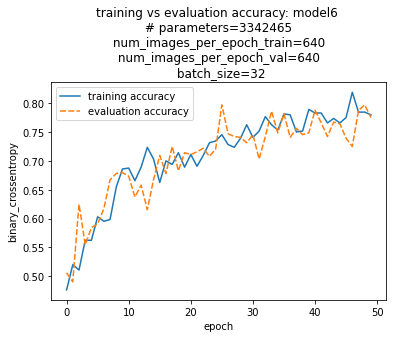

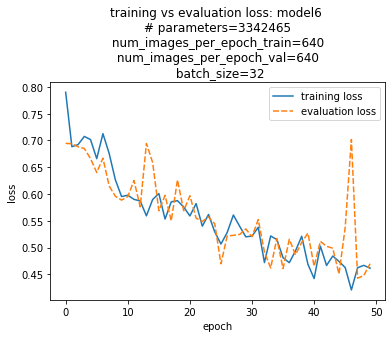

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.7802
Balanced Accuracy Score: 0.7802


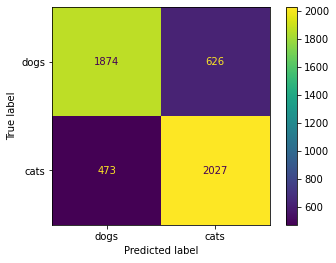

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 18.92%
Proportion of misclassified dogs: 25.04%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380
4,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model5,adam,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,True,0.729838,0.755666,0.6932,0.7936,0.770565,0.721192,0.3068,0.2064
5,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model6,rmsprop,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.773262,0.786726,0.7496,0.8108,0.798466,0.764041,0.2504,0.1892


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model6/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 10.0 **model7**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model7'
optimizer='sgd'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=150
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

Epoch 1/50
20/20 [==============================] - 4s 187ms/step - loss: 0.6928 - binary_accuracy: 0.4984 - val_loss: 0.6904 - val_binary_accuracy: 0.5609
Epoch 2/50
20/20 [==============================] - 3s 179ms/step - loss: 0.6917 - binary_accuracy: 0.5219 - val_loss: 0.6944 - val_binary_accuracy: 0.4656
Epoch 3/50
20/20 [==============================] - 3s 176ms/step - loss: 0.6922 - binary_accuracy: 0.5063 - val_loss: 0.6913 - val_binary_accuracy: 0.5453
Epoch 4/50
20/20 [==============================] - 4s 179ms/step - loss: 0.6869 - binary_accuracy: 0.5422 - val_loss: 0.6909 - val_binary_accuracy: 0.5031
Epoch 5/50
20/20 [==============================] - 3s 177ms/step - loss: 0.6916 - binary_accuracy: 0.5094 - val_loss: 0.6897 - val_binary_accuracy: 0.5266
Epoch 6/50
20/20 [==============================] - 3s 171ms/step - loss: 0.6893 - binary_accuracy: 0.5531 - val_loss: 0.6908 - val_binary_accuracy: 0.4906
Epoch 7/50
20/20 [==============================] - 3s 176ms/ste

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

3342465

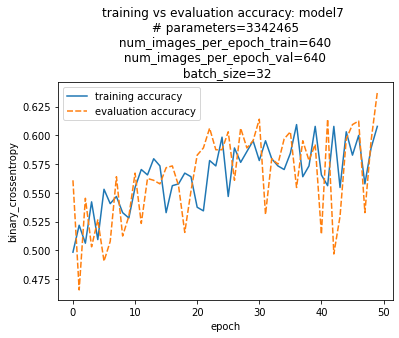

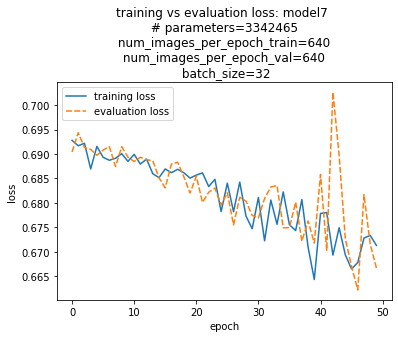

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.618
Balanced Accuracy Score: 0.618


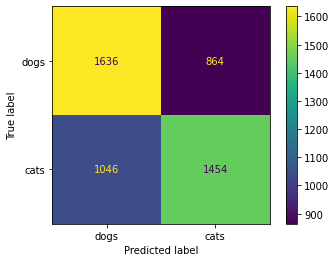

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 41.84%
Proportion of misclassified dogs: 34.56%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380
4,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model5,adam,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,True,0.729838,0.755666,0.6932,0.7936,0.770565,0.721192,0.3068,0.2064
5,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model6,rmsprop,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.773262,0.786726,0.7496,0.8108,0.798466,0.764041,0.2504,0.1892
6,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model7,sgd,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.631416,0.603570,0.6544,0.5816,0.609993,0.627265,0.3456,0.4184


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model7/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 11.0 **model8**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model8'
optimizer='adagrad'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=150
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

Epoch 1/50
20/20 [==============================] - 4s 189ms/step - loss: 0.6933 - binary_accuracy: 0.4844 - val_loss: 0.6926 - val_binary_accuracy: 0.5297
Epoch 2/50
20/20 [==============================] - 4s 180ms/step - loss: 0.6929 - binary_accuracy: 0.5125 - val_loss: 0.6924 - val_binary_accuracy: 0.5078
Epoch 3/50
20/20 [==============================] - 4s 185ms/step - loss: 0.6909 - binary_accuracy: 0.5328 - val_loss: 0.6925 - val_binary_accuracy: 0.4984
Epoch 4/50
20/20 [==============================] - 4s 181ms/step - loss: 0.6911 - binary_accuracy: 0.5219 - val_loss: 0.6942 - val_binary_accuracy: 0.4750
Epoch 5/50
20/20 [==============================] - 4s 180ms/step - loss: 0.6909 - binary_accuracy: 0.5109 - val_loss: 0.6935 - val_binary_accuracy: 0.4844
Epoch 6/50
20/20 [==============================] - 4s 183ms/step - loss: 0.6932 - binary_accuracy: 0.4922 - val_loss: 0.6931 - val_binary_accuracy: 0.4828
Epoch 7/50
20/20 [==============================] - 4s 182ms/ste

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

3342465

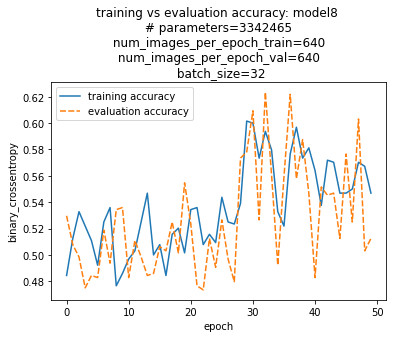

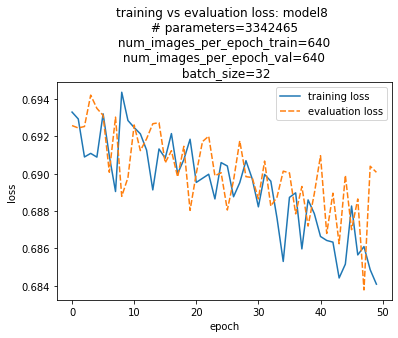

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.5378
Balanced Accuracy Score: 0.5378


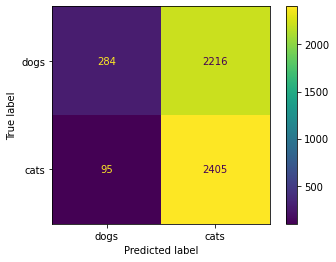

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 3.80%
Proportion of misclassified dogs: 88.64%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380
4,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model5,adam,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,True,0.729838,0.755666,0.6932,0.7936,0.770565,0.721192,0.3068,0.2064
5,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model6,rmsprop,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.773262,0.786726,0.7496,0.8108,0.798466,0.764041,0.2504,0.1892
6,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model7,sgd,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.631416,0.603570,0.6544,0.5816,0.609993,0.627265,0.3456,0.4184
7,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model8,adagrad,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.197291,0.675467,0.1136,0.9620,0.749340,0.520450,0.8864,0.0380


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model8/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

# 12.0 **model9**

In [ ]:
filename='TF_CNN_Sequential_Classification_Sigmoid_Simple.ipynb'
model_name='model9'
optimizer='adamax'
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=32
img_size=150
steps_per_epoch=20
epochs=50
validation_steps=20
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False

num_images_per_epoch_train:  640
num_images_per_epoch_val:  640


In [ ]:
! rm -r /content/train_1

## Create **train_1** train & eval images

In [ ]:
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

## Data Augmentation

In [ ]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [ ]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [ ]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [ ]:
if data_augmentation==True:
  del dog_train

In [ ]:
if data_augmentation==True:
  del dog_train_new

In [ ]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [ ]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [ ]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [ ]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [ ]:
if data_augmentation==True:
  del cat_train, cat_train_new

## Create **model**

In [ ]:
def create_model(img_size):
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid') #0 for cat, 1 for dog
  ])


  # Compile the model
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=[accuracy_metric]
  )

  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/content/train_1/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_1/eval',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Create a model to use with the imbalanced dataset
model = create_model(img_size)

# Print the model's summary
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)      

## Train **model**

In [ ]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,# num images = batch_size * steps
    epochs=epochs,
    validation_data=validation_generator,# num images = batch_size * steps
    validation_steps=validation_steps)

In [ ]:
test_i=plt.imread(os.path.join('/content/train_1/eval/dog',os.listdir('/content/train_1/eval/dog')[10]))

In [ ]:
test_i[0:224,0:224,:].shape

(224, 224, 3)

## Evaluate **model**

In [ ]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

3342465

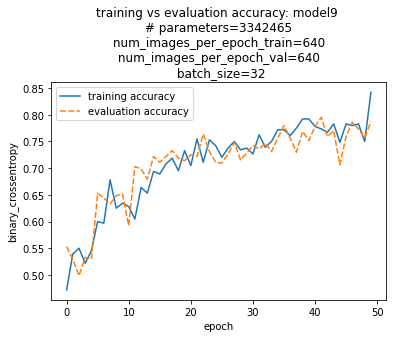

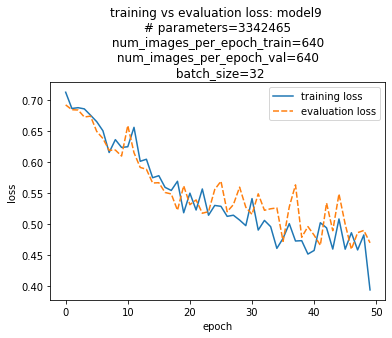

In [ ]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size)

In [ ]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")


Accuracy Score: 0.7768
Balanced Accuracy Score: 0.7767999999999999


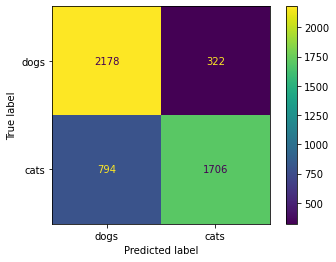

In [ ]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [ ]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [ ]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [ ]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 31.76%
Proportion of misclassified dogs: 12.88%


In [ ]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats
0,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model1,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,False,0.800821,0.770192,0.8580,0.7152,0.750788,0.834344,0.1420,0.2848
1,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model2,adam,binary_crossentropy,binary_accuracy,64,224,20,50,20,1280,1280,False,0.828374,0.823147,0.8408,0.8108,0.816311,0.835876,0.1592,0.1892
2,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model3,adam,binary_crossentropy,binary_accuracy,128,224,20,50,20,2560,2560,False,0.778844,0.820438,0.6980,0.9056,0.880868,0.749917,0.3020,0.0944
3,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model4,adam,binary_crossentropy,binary_accuracy,32,224,20,50,20,640,640,True,0.743929,0.787934,0.6740,0.8620,0.830049,0.725589,0.3260,0.1380
4,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model5,adam,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,True,0.729838,0.755666,0.6932,0.7936,0.770565,0.721192,0.3068,0.2064
5,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model6,rmsprop,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.773262,0.786726,0.7496,0.8108,0.798466,0.764041,0.2504,0.1892
6,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model7,sgd,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.631416,0.603570,0.6544,0.5816,0.609993,0.627265,0.3456,0.4184
7,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model8,adagrad,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.197291,0.675467,0.1136,0.9620,0.749340,0.520450,0.8864,0.0380
8,TF_CNN_Sequential_Classification_Sigmoid_Simpl...,model9,adamax,binary_crossentropy,binary_accuracy,32,150,20,50,20,640,640,False,0.796053,0.753534,0.8712,0.6824,0.732840,0.841223,0.1288,0.3176


In [ ]:
model.save(model_name) #save model

INFO:tensorflow:Assets written to: model9/assets


In [ ]:
model=tf.keras.models.load_model(model_name) #load model

In [ ]:
df_metrics.to_excel('df_metrics.xlsx')

In [ ]:
!zip -r /content/model1.zip /content/model1

  adding: content/model1/ (stored 0%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: content/model1/variables/variables.index (deflated 67%)
  adding: content/model1/saved_model.pb (deflated 89%)
  adding: content/model1/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model2.zip /content/model2

  adding: content/model2/ (stored 0%)
  adding: content/model2/assets/ (stored 0%)
  adding: content/model2/variables/ (stored 0%)
  adding: content/model2/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: content/model2/variables/variables.index (deflated 67%)
  adding: content/model2/saved_model.pb (deflated 90%)
  adding: content/model2/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model3.zip /content/model3

  adding: content/model3/ (stored 0%)
  adding: content/model3/assets/ (stored 0%)
  adding: content/model3/variables/ (stored 0%)
  adding: content/model3/variables/variables.data-00000-of-00001 (deflated 37%)
  adding: content/model3/variables/variables.index (deflated 67%)
  adding: content/model3/saved_model.pb (deflated 89%)
  adding: content/model3/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model4.zip /content/model4

  adding: content/model4/ (stored 0%)
  adding: content/model4/assets/ (stored 0%)
  adding: content/model4/variables/ (stored 0%)
  adding: content/model4/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: content/model4/variables/variables.index (deflated 67%)
  adding: content/model4/saved_model.pb (deflated 89%)
  adding: content/model4/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model5.zip /content/model5

  adding: content/model5/ (stored 0%)
  adding: content/model5/assets/ (stored 0%)
  adding: content/model5/variables/ (stored 0%)
  adding: content/model5/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: content/model5/variables/variables.index (deflated 67%)
  adding: content/model5/saved_model.pb (deflated 90%)
  adding: content/model5/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model6.zip /content/model6

  adding: content/model6/ (stored 0%)
  adding: content/model6/assets/ (stored 0%)
  adding: content/model6/variables/ (stored 0%)
  adding: content/model6/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: content/model6/variables/variables.index (deflated 67%)
  adding: content/model6/saved_model.pb (deflated 89%)
  adding: content/model6/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model7.zip /content/model7

  adding: content/model7/ (stored 0%)
  adding: content/model7/assets/ (stored 0%)
  adding: content/model7/variables/ (stored 0%)
  adding: content/model7/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/model7/variables/variables.index (deflated 59%)
  adding: content/model7/saved_model.pb (deflated 89%)
  adding: content/model7/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model8.zip /content/model8

  adding: content/model8/ (stored 0%)
  adding: content/model8/assets/ (stored 0%)
  adding: content/model8/variables/ (stored 0%)
  adding: content/model8/variables/variables.data-00000-of-00001 (deflated 35%)
  adding: content/model8/variables/variables.index (deflated 68%)
  adding: content/model8/saved_model.pb (deflated 89%)
  adding: content/model8/keras_metadata.pb (deflated 93%)


In [ ]:
!zip -r /content/model9.zip /content/model9

  adding: content/model9/ (stored 0%)
  adding: content/model9/assets/ (stored 0%)
  adding: content/model9/variables/ (stored 0%)
  adding: content/model9/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: content/model9/variables/variables.index (deflated 67%)
  adding: content/model9/saved_model.pb (deflated 89%)
  adding: content/model9/keras_metadata.pb (deflated 93%)


# Install **rclone**
This is so you can save your checkpoints weights to your actual google drive for restoration.

In [317]:
! curl https://rclone.org/install.sh | sudo bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4491  100  4491    0     0  42771      0 --:--:-- --:--:-- --:--:-- 42771
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    15  100    15    0     0    217      0 --:--:-- --:--:-- --:--:--   220
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0  58.0M      0 --:--:-- --:--:-- --:--:-- 58.0M
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/rclone.1  [text]  
  inflating:

You want to create a remote configuration with rclone.  Use the default recommendations.

In [ ]:
!rclone config

# Copy Content to **Google Drive** with **rclone**
Try to copy exisiting weights to a future directory to ensure rclone is configured right

This line tests the ability to copy known weights to a directory on you **Google Drive** with **rclone**

In [ ]:
!rclone copy "/content/"  remote:"/Colab_Notebooks/GitHub/TensorFlow_Examples/Basics/Wk4/content"